In [1]:
import pandas
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy
from glob import glob
import pySuStaIn

# Import data

In [2]:
df = pandas.ExcelFile('synthetic_data.xlsx').parse('Sheet1',header=0)

In [3]:
biomarkers = ['Biomarker 1', 'Biomarker 2', 'Biomarker 3',
       'Biomarker 4', 'Biomarker 5']
df[biomarkers].head()

,Biomarker 1,Biomarker 2,Biomarker 3,Biomarker 4,Biomarker 5
0,1,2,0,2,3
1,0,0,0,0,0
2,1,1,0,2,2
3,1,1,0,2,2
4,1,1,0,2,2


In [4]:
# convert to numeric
for col in biomarkers:
    df.loc[:,col] = pandas.to_numeric(df[col].values,
                                      errors='coerce')

In [5]:
# how many patients and controls do we have
select_patient = df['Category']=='Patient'
print(df.loc[select_patient,biomarkers].shape)
select_control = df['Category']=='Control'
print(df.loc[select_control,biomarkers].shape)

(20, 5)
(5, 5)


# Set up data for new version of SuStaIn
The objective here is two create to variables:

* p_NL -- a subject x region matrix indicating the p that a region is normal for a subject.
* p_score -- a subject x (region * score) matrix indicating p that a region is a given score.

Ps should be non-zero. 

In [6]:
patientdata = np.array(df.loc[select_patient,biomarkers],copy=True);
controldata = np.array(df.loc[select_control,biomarkers],copy=True);

N_Subjects = patientdata.shape[0]
N_Biomarkers = patientdata.shape[1]

ModelScores = np.array([1,2,3])
N_ModelScores = ModelScores.shape[0]

DataScores = np.array([0,1,2,3])
N_DataScores = DataScores.shape[0]

SuStaInLabels = biomarkers

prob_correct = np.sum(controldata==0,axis=0)/controldata.shape[0]

prob_dist = np.zeros((N_ModelScores+1,N_DataScores,N_Biomarkers))
for biomarker in range(N_Biomarkers):
    for datascore in range(N_DataScores):
        for modelscore in range(N_ModelScores+1): 
            if (datascore==modelscore):
                prob_dist[modelscore,datascore,biomarker] = prob_correct[biomarker]
            else:
                prob_dist[modelscore,datascore,biomarker] = (1-prob_correct[biomarker])/(N_DataScores-1)

prob_nl_dist = prob_dist[0,:,:]
    
prob_score_dist = prob_dist[1:,:,:]

prob_nl = np.ones((N_Subjects,N_Biomarkers))/(N_ModelScores+1)
for biomarker in range(N_Biomarkers):
    for datascore in range(N_DataScores):
        prob_nl[patientdata[:,biomarker]==DataScores[datascore],biomarker] = prob_nl_dist[datascore,biomarker]
 
prob_score = np.ones((N_Subjects,N_Biomarkers,N_ModelScores))/(N_ModelScores+1)
for biomarker in range(N_Biomarkers):
    for datascore in range(N_DataScores):
        for modelscore in range(N_ModelScores):
            prob_score[patientdata[:,biomarker]==DataScores[datascore],biomarker,modelscore] = prob_score_dist[modelscore,datascore,biomarker]      

In [7]:
score_vals = np.matlib.repmat(ModelScores,N_Biomarkers,1)

np.save('input/score_vals',score_vals)
np.save('input/SuStaInLabels',SuStaInLabels)
np.save('input/prob_nl',prob_nl)
np.save('input/prob_score',prob_score)

with pandas.ExcelWriter('input/data.xlsx') as writer:
    pandas.DataFrame(patientdata,columns=SuStaInLabels).to_excel(writer,sheet_name="score")
    pandas.DataFrame(prob_nl,columns=SuStaInLabels).to_excel(writer,sheet_name="p_0")
    pandas.DataFrame(prob_score[:,:,0],columns=SuStaInLabels).to_excel(writer,sheet_name="p_1")
    pandas.DataFrame(prob_score[:,:,1],columns=SuStaInLabels).to_excel(writer,sheet_name="p_2")
    pandas.DataFrame(prob_score[:,:,2],columns=SuStaInLabels).to_excel(writer,sheet_name="p_3")
    
biomarker_index = np.arange(len(SuStaInLabels))    
with pandas.ExcelWriter('input/probabilities.xlsx') as writer:
    for index in biomarker_index:
        temp_array = np.zeros((N_Subjects,5))
        temp_array[:,0] = patientdata[:,index]
        temp_array[:,1] = prob_nl[:,index]
        temp_array[:,2] = prob_score[:,index,0]
        temp_array[:,3] = prob_score[:,index,1]
        temp_array[:,4] = prob_score[:,index,2]
        pandas.DataFrame(temp_array,columns=['score','p_0','p_1','p_2','p_3']).to_excel(writer,sheet_name=SuStaInLabels[index])

# Run SuStaIn model

In [8]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

score_vals = np.load('input/score_vals.npy')
SuStaInLabels = np.load('input/SuStaInLabels.npy')
prob_nl = np.load('input/prob_nl.npy')
prob_score = np.load('input/prob_score.npy')

# restore np.load for future normal usage
np.load = np_load_old

outdir = 'output'

In [9]:
N_startpoints = 10
N_S_max = 3
N_iterations_MCMC = int(1e5)
output_folder = outdir
dataset_name = 'sample_data'
sustain_input = pySuStaIn.OrdinalSustain(prob_nl,
                                  prob_score,
                                  score_vals,
                                  SuStaInLabels,
                                  N_startpoints,
                                  N_S_max, 
                                  N_iterations_MCMC, 
                                  output_folder, 
                                  dataset_name, 
                                  False)

Found pickle file: output/pickle_files/sample_data_subtype0.pickle. Using pickled variables for 0 subtype.


/opt/homebrew/Caskroom/miniconda/base/envs/sustain_tutorial_env/lib/python3.11/site-packages/pySuStaIn/OrdinalSustain.py:469: UserWarning: Both labels and an order have been given. The labels will be reordered according to the given order!
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/homebrew/Caskroom/miniconda/base/envs/sustain_tutorial_env/lib/python3.11/site-packages/pySuStaIn/AbstractSustain.py:235: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Found pickle file: output/pickle_files/sample_data_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: output/pickle_files/sample_data_subtype2.pickle. Using pickled variables for 2 subtype.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/homebrew/Caskroom/miniconda/base/envs/sustain_tutorial_env/lib/python3.11/site-packages/pySuStaIn/AbstractSustain.py:244: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig0.show()


ValueError: too many values to unpack (expected 8)

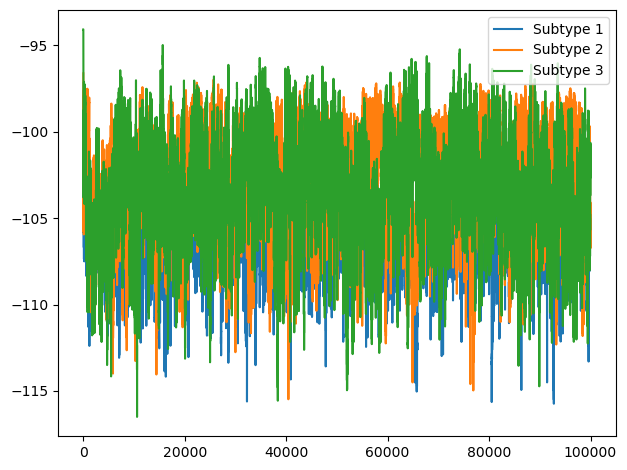

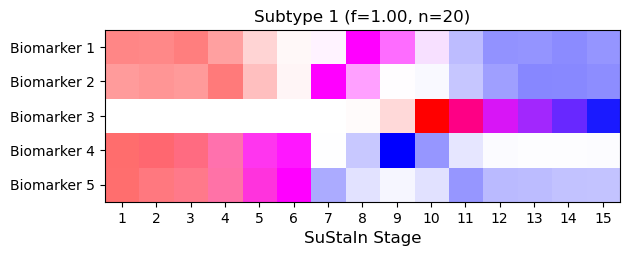

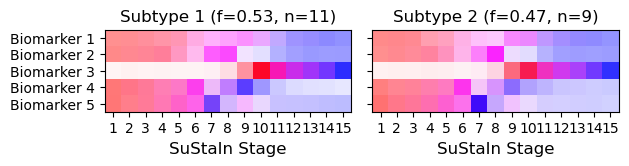

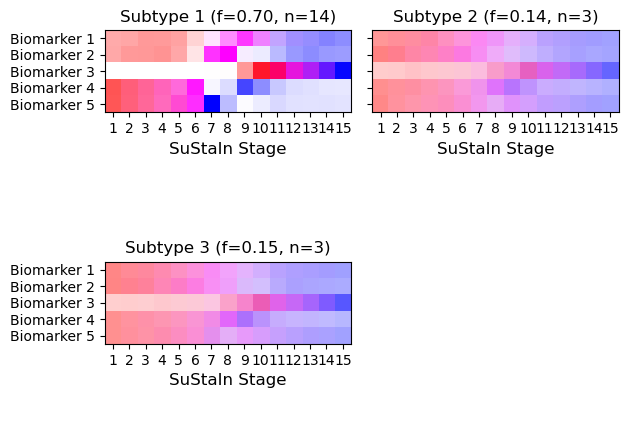

In [11]:
[samples_sequence, samples_f, 
ml_subtype, prob_ml_subtype, ml_stage, 
prob_ml_stage, prob_subtype_stage, samples_likelihoods, fig0] = sustain_input.run_sustain_algorithm(plot=True)